### Feedforward 
```
MNIST
DataLoader, Transformation
Multilayer Neural Net, activation function
Loss and Optimizer
Training Loop (batch training)
Model evaluation
GPU support


In [30]:
import torch
import torch.nn as nn 
import torchvision
# from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys

In [16]:

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs\\MNIST-2')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
# hyper parameters

input_size = 784 # image size = 28*28, reshapes to 1D
hidden_size = 100
num_classes = 10 # 0,1,2 .... 9
num_epochs = 2
batch_size = 64
learning_rate = 0.001


MNIST Dataset

In [19]:
train_dataset = torchvision.datasets.MNIST(root='data', train=True,
                            transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='data', train=False,
                                          transform=transforms.ToTensor())

In [20]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Data loader

In [21]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

In [22]:
example = iter(train_loader)
samples, labels = example.__next__()
print(samples.shape, labels.shape) # 64 smaples(batch_size), 1 channel, 28*28 image size

torch.Size([64, 1, 28, 28]) torch.Size([64])


Adding images to Tensorboard

In [23]:
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)

In [24]:
# tensorboard --logdir=runs #bash

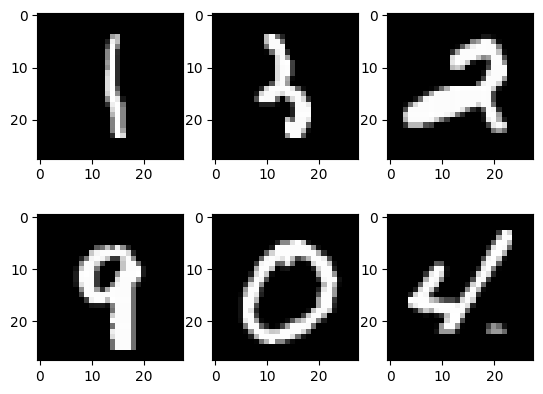

In [25]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

Model

In [26]:
class NeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

        # no sigmoid is defining because in loss fun(CrossEntropy) in automatically takes it

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)

        return out
    
model = NeuralNet(input_size, hidden_size, num_classes)

Loss and Optimizer

In [27]:
criterion = nn.CrossEntropyLoss() #multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Adding model-graph to Tensorboard


In [28]:
writer.add_graph(model, samples.reshape(-1, 28*28))

Training loop

In [29]:
n_total_steps = len(train_loader) # total batches - 600

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #i -> iterations
        # 100, 1, 28, 28
        #reshaping 2D -> 1D
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        #forward pass and loss
        outputs = model(images) # forward(x)
        loss = criterion(outputs, labels)

        #backward
        loss.backward()

        #update
        optimizer.step()

        #zero_grad
        optimizer.zero_grad()

        #checking accuray while training
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}, iter:{i+1}/{n_total_steps}, loss: {loss.item():.4f}')

            writer.add_scalar('training_loss', running_loss / 100, epoch*n_total_steps + 1)
            writer.add_scalar('accuracy', running_correct /100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0.0


epoch: 1/2, iter:100/938, loss: 0.5050
epoch: 1/2, iter:200/938, loss: 0.4529
epoch: 1/2, iter:300/938, loss: 0.3765
epoch: 1/2, iter:400/938, loss: 0.1883
epoch: 1/2, iter:500/938, loss: 0.2212
epoch: 1/2, iter:600/938, loss: 0.4373
epoch: 1/2, iter:700/938, loss: 0.3213
epoch: 1/2, iter:800/938, loss: 0.2271
epoch: 1/2, iter:900/938, loss: 0.1407
epoch: 2/2, iter:100/938, loss: 0.1610
epoch: 2/2, iter:200/938, loss: 0.1283
epoch: 2/2, iter:300/938, loss: 0.2174
epoch: 2/2, iter:400/938, loss: 0.2967
epoch: 2/2, iter:500/938, loss: 0.0763
epoch: 2/2, iter:600/938, loss: 0.0484
epoch: 2/2, iter:700/938, loss: 0.0717
epoch: 2/2, iter:800/938, loss: 0.1174
epoch: 2/2, iter:900/938, loss: 0.1056


Testing / Evaulation

In [34]:
labeled = []
preds = []

with torch.no_grad():
    nof_correct = 0
    nof_samples = 0
    for images, labels in test_loader:
        
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        #returns value, index
        _, predictions = torch.max(outputs, 1) #values, dim

        nof_samples += labels.shape[0]  #100
        nof_correct += (predictions == labels).sum().item()

        class_predictions = [F.softmax(output, dim=0) for output in outputs]

        preds.append(class_predictions)
        labeled.append(predictions)

    preds = torch.cat([torch.stack(batch) for batch in preds])
    labeled = torch.cat(labeled)

    acc = nof_correct / nof_samples * 100
    print(f'accuracy = {acc}')

    classes = range(10)
    for i in classes:
        labels_i = labeled == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()



accuracy = 95.58


Testing single image

In [63]:
test1 = iter(test_loader)
images, samples = test1.__next__()

In [68]:
images.shape

torch.Size([100, 1, 28, 28])

tensor([9])


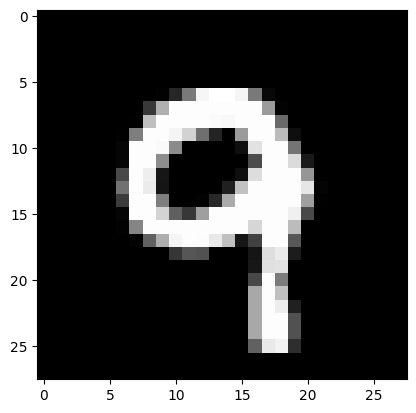

In [70]:
img = images[99][0]

plt.imshow(img, cmap='gray')
plt.imshow

test = img.reshape(-1, 28*28)
output = model(test)
#returns value, index
_, predictions = torch.max(output, 1) #values, dim

print(predictions)
